<a href="https://colab.research.google.com/github/GeoTurkey/GMT_COURSES/blob/main/AMZN_STOCK_PRICE_PyTorch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import pandas_datareader as web

import matplotlib.pyplot as plt
from matplotlib import rc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Get the stock quote 
df = web.DataReader('AMZN', data_source='yahoo', start='2006-01-01', end='2018-01-01') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,47.849998,46.250000,47.470001,47.580002,7582200,47.580002
2006-01-04,47.730000,46.689999,47.490002,47.250000,7440900,47.250000
2006-01-05,48.200001,47.110001,47.160000,47.650002,5417200,47.650002
2006-01-06,48.580002,47.320000,47.970001,47.869999,6152900,47.869999
2006-01-09,47.099998,46.400002,46.549999,47.080002,8943100,47.080002
...,...,...,...,...,...,...
2017-12-22,1174.619995,1167.829956,1172.079956,1168.359985,1585100,1168.359985
2017-12-26,1178.319946,1160.550049,1168.359985,1176.760010,2005200,1176.760010
2017-12-27,1187.290039,1175.609985,1179.910034,1182.260010,1867200,1182.260010


In [ ]:
torch.cuda.is_available()


True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'Tesla T4'

In [ ]:
torch.cuda.memory_allocated()

64478720

In [ ]:
torch.cuda.memory_reserved()

2581594112

In [ ]:
df.shape

(3020, 6)

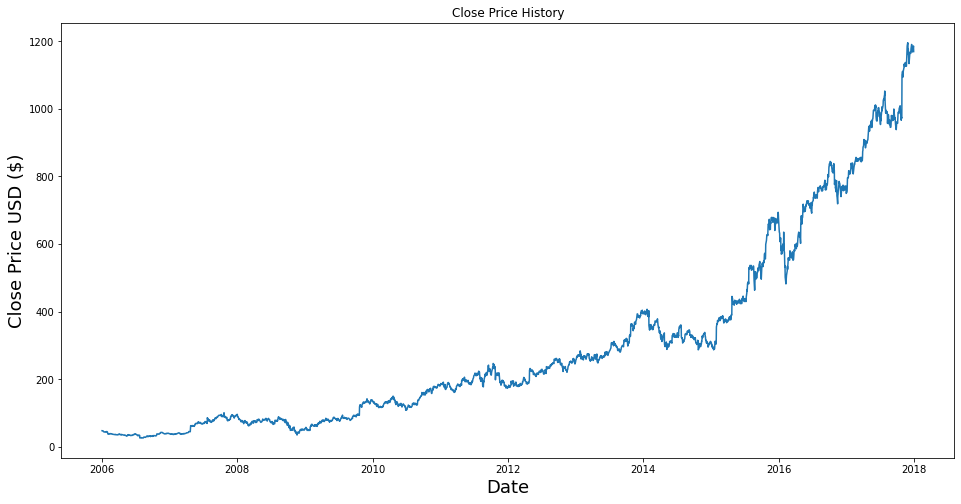

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
data = df.filter(['Close'])
price = df[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3020 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2400, 20, 1)
y_train.shape =  (2400, 1)
x_test.shape =  (600, 20, 1)
y_test.shape =  (600, 1)


In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor).cuda()
x_test = torch.from_numpy(x_test).type(torch.Tensor).cuda()
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).cuda()
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor).cuda()
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor).cuda()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=1, hidden_dim=128, output_dim=1, num_layers=1).cuda()
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
num_epochs = 500
hist = np.zeros(num_epochs)
hist_val = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test)
      val_loss = criterion(y_test_pred, y_test_lstm)
      hist_val[t] = val_loss.item()
    
    if t % 10 == 0 and t !=0:
      print("Epoch ", t, "Train Loss: {}  Val Loss: {}".format(loss.item(), val_loss.item()))

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  10 Train Loss: 0.09410244226455688  Val Loss: 0.5330476760864258
Epoch  20 Train Loss: 0.032647889107465744  Val Loss: 0.5730503797531128
Epoch  30 Train Loss: 0.020400354638695717  Val Loss: 0.658696174621582
Epoch  40 Train Loss: 0.019251640886068344  Val Loss: 0.5820934176445007
Epoch  50 Train Loss: 0.01689259335398674  Val Loss: 0.5647669434547424
Epoch  60 Train Loss: 0.01443229429423809  Val Loss: 0.4939538836479187
Epoch  70 Train Loss: 0.010823292657732964  Val Loss: 0.44095921516418457
Epoch  80 Train Loss: 0.005881808698177338  Val Loss: 0.36300501227378845
Epoch  90 Train Loss: 0.0013543573440983891  Val Loss: 0.28007954359054565
Epoch  100 Train Loss: 0.0016273189103230834  Val Loss: 0.25713101029396057
Epoch  110 Train Loss: 0.0011360273929312825  Val Loss: 0.2678287923336029
Epoch  120 Train Loss: 0.001065558404661715  Val Loss: 0.25689321756362915
Epoch  130 Train Loss: 0.0009510531090199947  Val Loss: 0.23866185545921326
Epoch  140 Train Loss: 0.0008752876892685

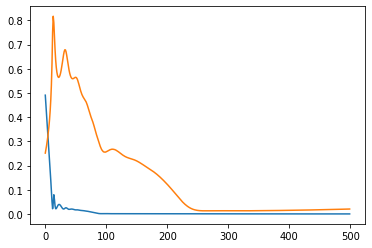

In [ ]:
plt.plot(hist)
plt.plot(hist_val)

In [ ]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().cpu().numpy())

In [ ]:
train_data = data[:len(y_train)]
train_data["Train Predict"] = y_train_pred
valid = data[len(y_train)+lookback:]
valid["Test"] = y_test 
valid['True Predictions'] = y_test_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
train_data

,Close,Train Predict
Date,,
2006-01-03,47.580002,45.169083
2006-01-04,47.250000,45.086216
2006-01-05,47.650002,44.898243
2006-01-06,47.869999,44.327663
2006-01-09,47.080002,43.679657
...,...,...
2015-07-10,443.510010,531.874878
2015-07-13,455.570007,535.468628
2015-07-14,465.570007,538.553711


In [ ]:
valid

,Close,Test,True Predictions
Date,,,
2015-08-14,531.520020,531.520020,546.461304
2015-08-17,535.219971,535.219971,548.627014
2015-08-18,535.020020,535.020020,550.769409
2015-08-19,532.919983,532.919983,552.764832
2015-08-20,515.780029,515.780029,554.428040
...,...,...,...
2017-12-22,1168.359985,1168.359985,1032.835693
2017-12-26,1176.760010,1176.760010,1032.633179
2017-12-27,1182.260010,1182.260010,1032.415771


## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

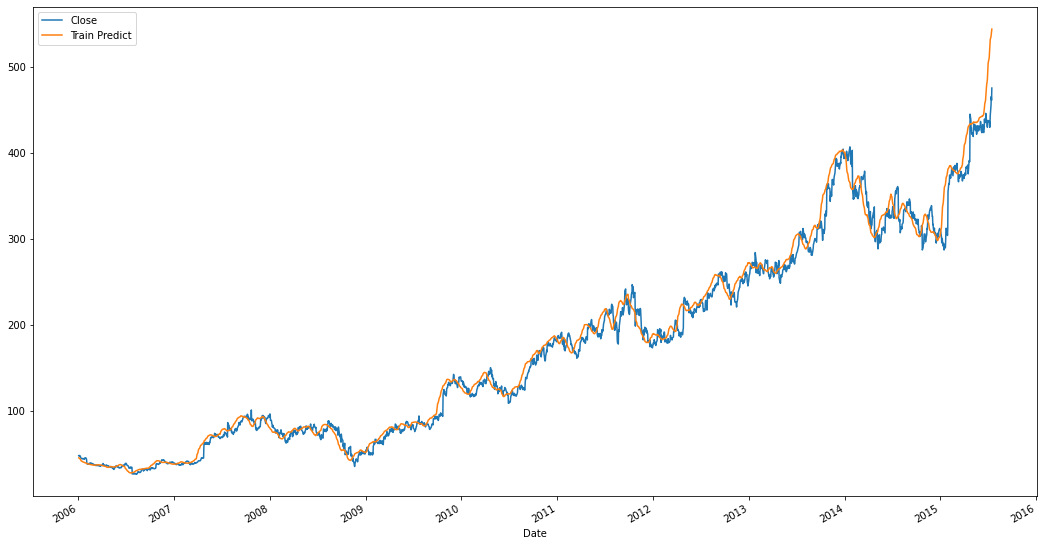

In [ ]:
train_data.plot(figsize=(18,10));

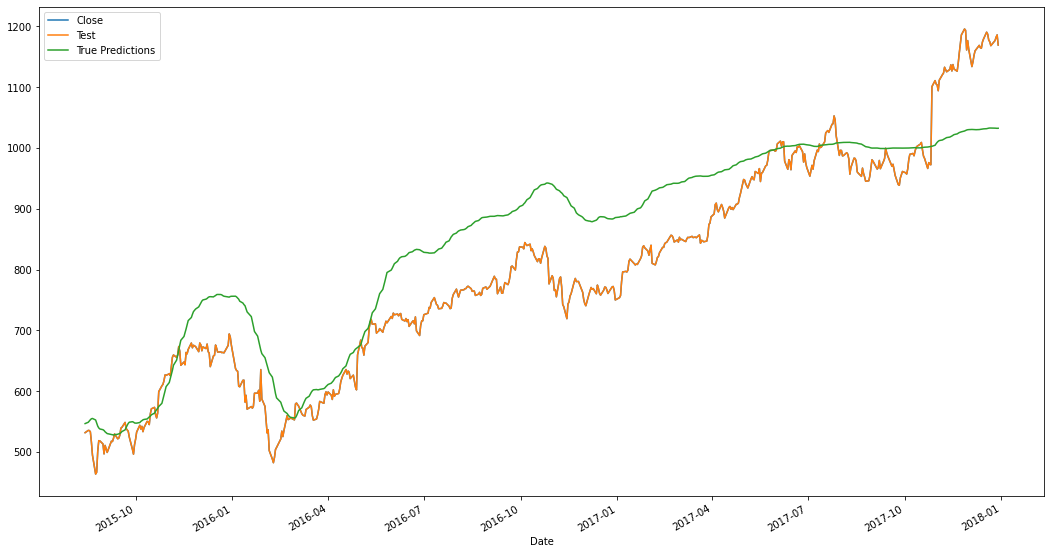

In [ ]:
valid.plot(figsize=(18,10));

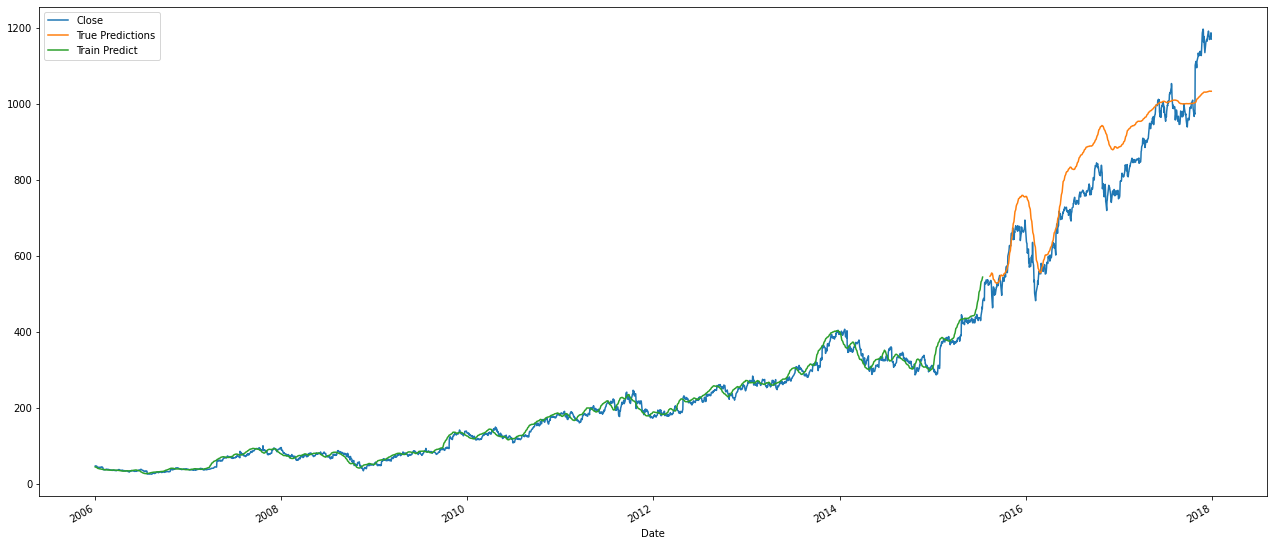

In [ ]:
data.plot(figsize=(22,10))
#train_data['Train_Predict'].plot()
valid['True Predictions'].plot()
train_data["Train Predict"].plot()
plt.legend()

In [ ]:
# calculate root mean squared error of the training result based on last iteration (epoch) and non-scaled values.

trainScore = math.sqrt(mean_squared_error(y_train_pred, y_train))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_pred, y_test))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 8.9685 RMSE
Test Score: 83.6432 RMSE
